In [22]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [23]:
# read in dataset Jill
dset = pd.read_csv('AnnieCheung1.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

9295
15.491666666666667


In [24]:
#Variables
f=10

# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

Autonomic: 2.695 minutes
Autonomic light: 7.64 minutes
Normal breathing: 3.43333333333 minutes
Cardio: 0.673333333333 minutes
 Total: 14.4416666667 minutes


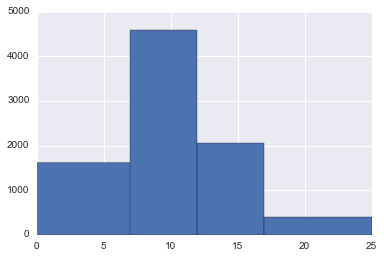

In [29]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/600
b2=n[1]/600
b3=n[2]/600
b4=n[3]/600

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print(" Total: " + str(b1+b2+b3+b4) + " minutes")

In [25]:
f = d

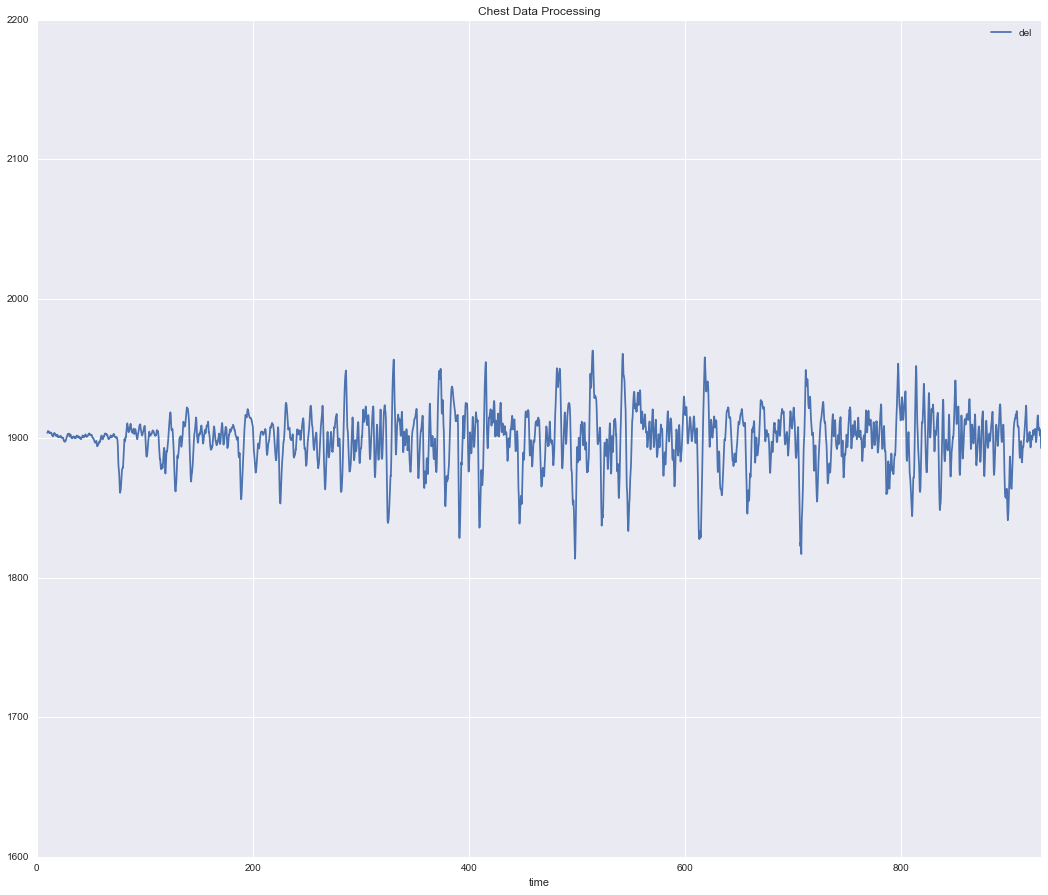

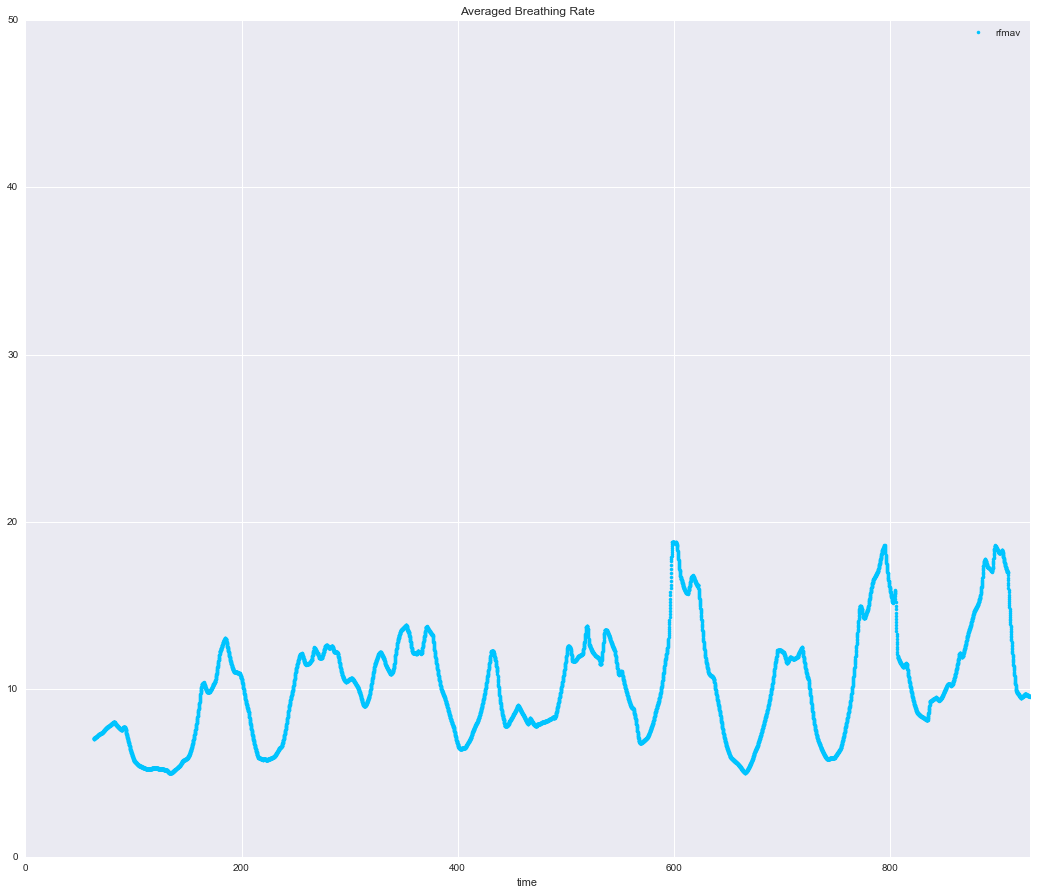

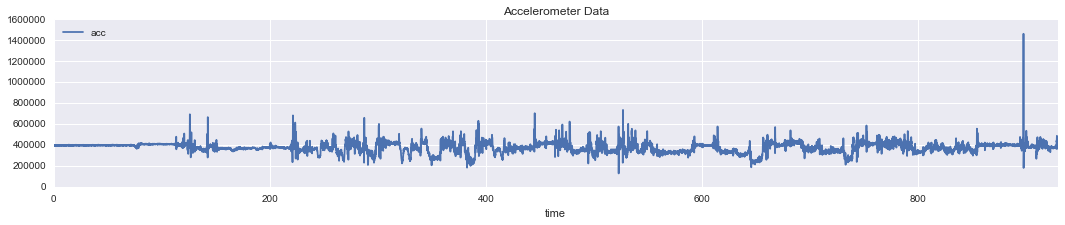

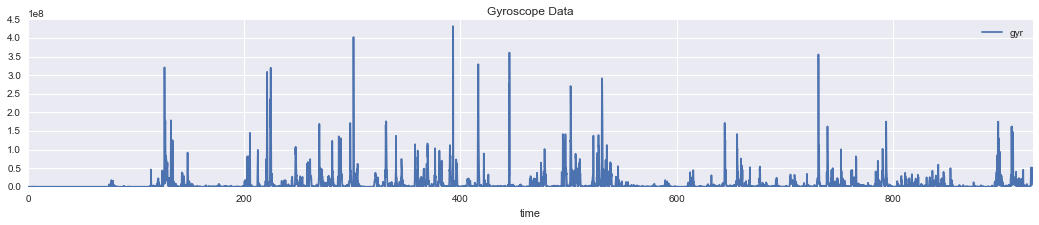

In [26]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [27]:
print(d[::1000]) # every thousandth line of the processed dataset

      index  chest  belly   ax   ay   az    gx    gy   gz   time  ...   \
0         0   2472   2715  120  526  319   215  -178  -79    0.0  ...    
1000   1000   2496   2701   92  487  406   233  -254  -16  100.0  ...    
2000   2000   2463   2612  115  559  204   465 -1405   80  200.0  ...    
3000   3000   2381   2628  127   81  639   451  -236 -278  300.0  ...    
4000   4000   2387   2577  103  423  460   716  -217  -88  400.0  ...    
5000   5000   2361   2553  184  560  -29  -684  -609   20  500.0  ...    
6000   6000   2435   2701   44 -129  615   130   640  137  600.0  ...    
7000   7000   2467   2690 -168 -141  566   178   236 -106  700.0  ...    
8000   8000   2427   2639   -8 -400  435  -706  -416   16  800.0  ...    
9000   9000   2355   2614  108  428  480 -3655 -2350 -309  900.0  ...    

                                               fbtime  rlast  flast  \
0                                               [nan]    NaN    NaN   
1000            [8.2, 7.6, 12.1, 8.2, 5.4, 

In [28]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,2472,2715,120,526,319,215,-178,-79,0.0,...,[nan],NaN,NaN,NaN,NaN,NaN,392837,84150,1900,1600
1,1,2471,2716,116,524,323,188,-161,-47,0.1,...,[nan],NaN,NaN,NaN,NaN,NaN,392361,63474,1900,1600
2,2,2474,2717,118,524,331,286,-185,-90,0.2,...,[nan],NaN,NaN,NaN,NaN,NaN,398061,124121,1900,1600
3,3,2472,2715,121,524,319,221,-205,-100,0.3,...,[nan],NaN,NaN,NaN,NaN,NaN,390978,100866,1900,1600
4,4,2473,2715,118,527,321,330,-200,-57,0.4,...,[nan],NaN,NaN,NaN,NaN,NaN,394694,152149,1900,1600
5,5,2474,2716,124,528,321,322,-164,-19,0.5,...,[nan],NaN,NaN,NaN,NaN,NaN,397201,130941,1900,1600
6,6,2473,2715,120,527,323,303,-178,-53,0.6,...,[nan],NaN,NaN,NaN,NaN,NaN,396458,126302,1900,1600
7,7,2470,2712,120,526,323,211,-212,-51,0.7,...,[nan],NaN,NaN,NaN,NaN,NaN,395405,92066,1900,1600
8,8,2469,2708,124,526,323,283,-153,-11,0.8,...,[nan],NaN,NaN,NaN,NaN,NaN,396381,103619,1900,1600
9,9,2471,2704,118,527,323,293,-194,-69,0.9,...,[nan],NaN,NaN,NaN,NaN,NaN,395982,128246,1900,1600
